In [1]:
## Loading Libraries
import pandas as pd
import numpy as np
import networkx as nx
from random import uniform
import random
from copy import deepcopy
import warnings
import pickle
import datetime
from time import gmtime, strftime
import pytz
import winsound
import time

# import power_index_calculator as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from generateRandSeed import generateRandSeed
from plot_simulation_output import plot_simulation_output
from TimePolicy_generator import TimePolicy_generator
from Simulate_SIR_Time import Simulate_SIR_Time

In [3]:
with open('FaceBookGraph','rb') as f:
    FB_Graph = pickle.load(f)

# **Run Your Simulation**

In the below example, we create an Erdos-Renyi graph and we run the simulation and plot the outputs.

The Peak is 0.937, and the Cascade is 1.000, and Peak_int is 2


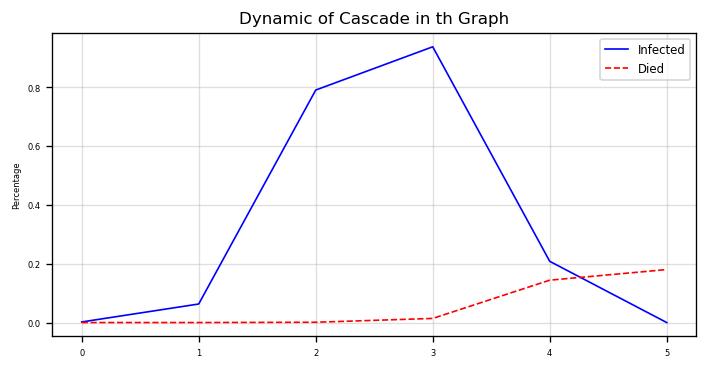

Wall time: 1.68 s


()

In [4]:
%%time
# Example
n = 1000
d = 40
c = 0.6
G = nx.erdos_renyi_graph(n,d/n)
# G = deepcopy(FB_Graph)
edge_weight = dict(zip(G.edges(),[c for x in range(len(G.edges()))]))
nx.set_edge_attributes(G,edge_weight,'weight')

method = 'Transmission'
out = Simulate_SIR_Time (deepcopy(G),Maximum_Time=1000,
                       Seasons=[50,100,150,200],P_seasons = [1,1,1,1],
                       Seeds = generateRandSeed(2,G), 
                       n_dr=1, q_die=0.2, n_exposed=0,q_symptotic=0, q_s=0.5,
                       how='Transmission',
                       time_policy={'mode':'stochastic','stochastic':{'p':1},
                                    'deterministic':{'group_num':2,'method':'divide'}},
                       pnt=False)

print('The Peak is {:0.3f}, and the Cascade is {:0.3f}, and Peak_int is {}'.format(
    out['Peak'],out['Cascade'],out['Peak_int']))
plot_simulation_output(Graphsize=G.number_of_nodes(),data = out,module=['Infected','Died'])

In [5]:
%%time
OUT_dic = {}
Sim_count = 0
# SEEDS_NUMBER = list(np.arange(1,30,5)) + list(np.arange(30,150,10))
Cs = list(np.arange(0.001,0.02,0.001))+ list(np.arange(0.02,0.1,0.01)) + list(np.arange(0.1,0.5,0.1))
# N = [2000,4000]
# Seed = [20,40]
for c in Cs:
    
    for i in range(1):
        duration = 500  # milliseconds
        freq = 440  # Hz
        winsound.Beep(freq, duration)

    
    OUT = {'deter':{'Cascade':list(),'Peak':list(),'Peak_int':list()},
           'stoch':{'Cascade':list(),'Peak':list(),'Peak_int':list()}}
    n = 1000
    d = 10
    c= c
    number_seed = 20
    repeat = 30
    for i in range(repeat):
        if i%15==0:
            now = datetime.datetime.now() 
            print ("\n{} from {}\nCurrent time is: ".format(i,repeat))
            print (now.strftime("%H:%M:%S"))

        G = nx.erdos_renyi_graph(n,d/n)
    #     G = deepcopy(FB_Graph)
        edge_weight = dict(zip(G.edges(),[c for x in range(len(G.edges()))]))
        nx.set_edge_attributes(G,edge_weight,'weight')


#         out = Simulate_SIR_Time(deepcopy(G),Maximum_Time=1000,
#                            Seasons=[50,100,150,200],P_seasons = [1,1,1,1],
#                            Seeds = generateRandSeed(number_seed,G), 
#                            n_dr=17, q_die=0.2, n_exposed=3,q_symptotic=0.5, q_s=0.1,
#                            how='Transmission',
#                            time_policy={'mode':'deterministic','stochastic':{'p':0.5},
#                                         'deterministic':{'group_num':2,'method':'divide'}},
#                            pnt=False)
#         OUT['deter']['Cascade'].append(out['Cascade'])
#         OUT['deter']['Peak'].append(out['Peak'])
#         OUT['deter']['Peak_int'].append(out['Peak_int'])

        OUT['deter']['Cascade'].append(0)
        OUT['deter']['Peak'].append(0)
        OUT['deter']['Peak_int'].append(0)

        out = Simulate_SIR_Time(deepcopy(G),Maximum_Time=1000,
                           Seasons=[50,100,150,200],P_seasons = [1,1,1,1],
                           Seeds = generateRandSeed(number_seed,G), 
                           n_dr=17, q_die=0.2, n_exposed=3,q_symptotic=0.5, q_s=0.1,
                           how='Transmission',
                           time_policy={'mode':'stochastic','stochastic':{'p':1},
                                        'deterministic':{'group_num':2,'method':'stochastic'}},
                           pnt=False)
        OUT['stoch']['Cascade'].append(out['Cascade'])
        OUT['stoch']['Peak'].append(out['Peak'])
        OUT['stoch']['Peak_int'].append(out['Peak_int'])

    deter = pd.DataFrame(OUT['deter'])
    stoch = pd.DataFrame(OUT['stoch'])
    
    ## Output
    Sim_count+=1
    OUT_dic['Simulation_'+str(Sim_count)] = {'configs':'n='+str(n)+' d='+str(d)+' c='+str(c)+' seeds='+str(number_seed)+' repeat='+str(repeat),
                                             'deter':deter.describe(),'stoc':stoch.describe(),'seed':number_seed,'repeat':repeat,'c':c,'n':n}
    
    
    ## Progress
    now = datetime.datetime.now() 
    print ("\n{} from {}".format(Sim_count,len(Cs)))
    print ("for n={}\nCurrent time is: ".format(c))
    print (now.strftime("%H:%M:%S"))
    print ("*****************************************\n")
        
        
        
for i in range(3):
    time.sleep(0.5)
    duration = 500  # milliseconds
    freq = 840  # Hz
    winsound.Beep(freq, duration)


0 from 30
Current time is: 
17:57:34


KeyboardInterrupt: 

In [6]:
out_list = []

for k,v in OUT_dic.items():
    out_list.append([v['c'],
                     v['deter'].loc['mean','Cascade'],
                     v['stoc'].loc['mean','Cascade'],
                     v['deter'].loc['std','Cascade'],
                     v['stoc'].loc['std','Cascade']])

out_df = pd.DataFrame(out_list,columns=['c','deter_Cascade','stoc_Cascade','deter_std','stoc_std'])
out_df = out_df[['c','stoc_Cascade']].rename(columns={'stoc_Cascade':'Cascade'})
# out_df['diff'] = out_df['stoc_Cascade'] - out_df['deter_Cascade']
# out_df.to_csv('C_diff.csv')
out_df

,c,Cascade
